# 15. 프로젝트 : 다양한 OCR모델 비교하기
우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

1. OCR을 활용하여 구현하려는 서비스의 기획

    - 증강현실(Augmented Reality)을 기반으로 한 실시간 번역앱의 문자인식 기술 평가
        
        해외여행을 다니다 보면 모르는 외국어에 당황 할 때가 있습니다. 이런 상황을 대비해 사용 할 수 있는 어플리케이션을 개발하려합니다.  
        개발 과정 중, 번역하기 이전에 카메라 이미지에서 1. 문자를 인식하고, 2. text로 변환하는 과정 또한 매우 중요하다고 생각합니다.  
        따라서 정확한 출력을 얻어서 올바른 번역을 하기 위해 OCR open source 중 적합한 모듈을 찾고자 합니다.

2. 모델 평가기준

    - 여행 중 마주하는 외국어는 대부분 일상적인 단어를 포함 할 것입니다.
        - 테스트 데이터는 아래와 같은 이미지들을 사용합니다.
            1. 메뉴 이미지
            2. 관광지 설명 가이드
            3. 생산품에 대한 안내
            4. 도로 표지판
            5. 관광 안내 표지판
    - 앱이 가진 목적상, 이미지는 일상적인 이미지여야 하므로 synthetic image는 사용하지 않아야 합니다.
    - 위의 이미지 들에 대해 얼마나 인식률이 높은지, 인식된 텍스트가 실제로 올바른 정보를 포함하는지를 중점으로 판단하겠습니다.

---
## before project

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

import keras_ocr
import pytesseract

---
## Step 1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

In [4]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/img_src'
data_path

'/aiffel/aiffel/ocr_python/img_src'

In [5]:
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
img_src_google = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/img_src/img1.png',
 '/aiffel/aiffel/ocr_python/img_src/img2.png',
 '/aiffel/aiffel/ocr_python/img_src/img3.png',
 '/aiffel/aiffel/ocr_python/img_src/img4.png',
 '/aiffel/aiffel/ocr_python/img_src/img5.png']

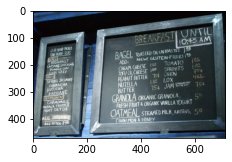

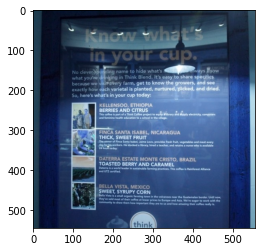

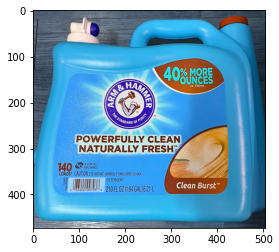

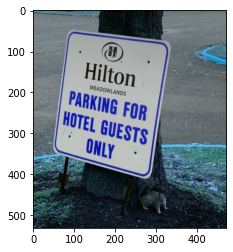

In [28]:
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(1, 5, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

---
## Step 2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

### 1. Google OCR API

In [11]:
# 다운받은 google ocr api 인증키 경로 저장 확인
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.getenv('HOME') + '/aiffel/ocr_python/img_src_google/my_google_api_key.json'

E1111 08:19:59.995178109      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


-rw-r--r-- 1 root root 2339 Nov 11 06:21 /aiffel/aiffel/ocr_python/my_google_api_key.json


In [12]:
def detect_text(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    #     for text in texts:
    print('\n"{}"'.format(texts[0].description))
    
    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in texts[0].bounding_poly.vertices])
    
    print('bounds: {}'.format(','.join(vertices)))
    
    if response.error.message:
        raise Exception(
        '{}\nFor more info on erroe messages, check:' 
        'https://cloud.google.com/apis/design/errors'.format(
        response.error.message))
    
    return texts[0].description

In [26]:
# ocr api 함수 호출
google_ocr_result = []
for path in file_path:
    result = detect_text(path)
    google_ocr_result.extend(result)
    print('------------------------------')

Texts:

"OUR HAND-PACKED
FAIR TRADE TEAS
BLACK
BREAKFAST
LAPSANG SOUCHONG
BOMBAY CHAI
EARL GREY
GREEN
SPRING JASMINE
GENMAICHA
HOJICHA
KARIGANE
HERBAL DECAF
CHAMOMILE
MASALA TRUFFLE
MINT DETOX
ALL ORGANIC
ALL SIZES 275
BREAKFAST UNTIL
10:45 AM
BAGEL TOASTED OR UN TOASTED 195
ADD:
NEW! GLUTEN-FREE! 195
CREAM CHEESE 100
TOFU CR. CHEESE 100
PEANUT BUTTER 754 ONION
125 LOX
754 JAM
TOMATO
SPROUTS
125
1⁹0
75¢
425
NUTELLA
BUTTER
GRANOLA ORGANIC GRANOLA,
FRESH FRUIT & ORGANIC VANILLA YOGURT
OATMEAL STEAMED MILK, RAISINS, 525
CINNAMON & HONEY
STRAWBERRY
RASPBERRY
754
52⁹"
bounds: (32,57),(664,57),(664,423),(32,423)
------------------------------
Texts:

"Know what's
in your cup.
No clever-sounding name to hide what's heen you always know
what you're drinking in Think Blend. It's easy to share specifics
because we visit every farm, get to know the growers, and see
exactly how each varietal is planted, nurtured, picked, and dried.
So, here's what's in your cup today:
KELLENSOO, ETHIOPIA
BERRIES A

### 2. Keras-ocr

In [14]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [15]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

결과에 대해 시각화를 해보겠습니다.

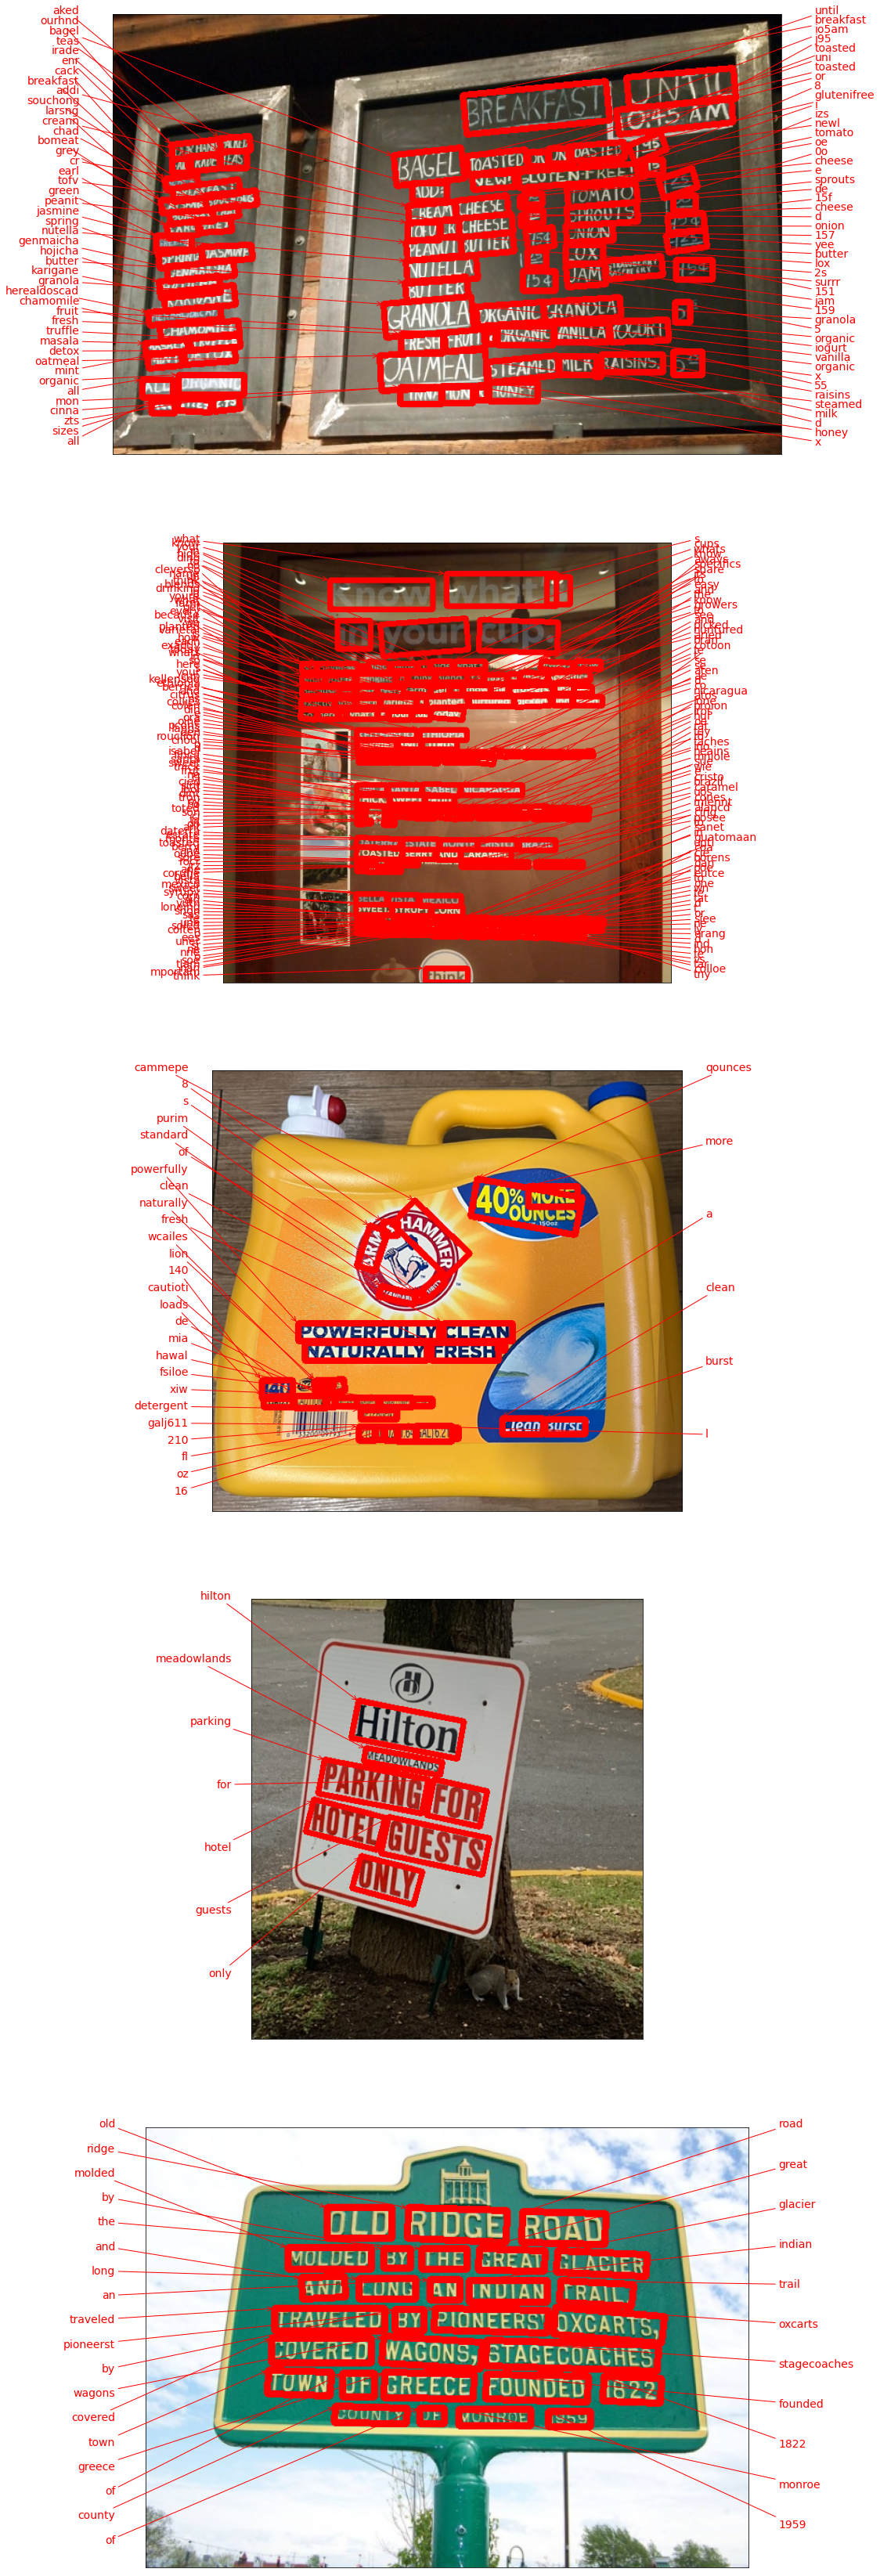

In [37]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 60))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract

In [22]:
from PIL import Image
from pytesseract import Output

In [24]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

    
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract'
    
    
tesseract_result_path = []
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir)
    tesseract_result_path.extend(image_path_list)

E1111 08:33:28.478381504      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/tesseract/0000.png
/aiffel/aiffel/ocr_python/tesseract/0001.png
/aiffel/aiffel/ocr_python/tesseract/0002.png
/aiffel/aiffel/ocr_python/tesseract/0003.png
/aiffel/aiffel/ocr_python/tesseract/0004.png
/aiffel/aiffel/ocr_python/tesseract/0005.png
/aiffel/aiffel/ocr_python/tesseract/0006.png
/aiffel/aiffel/ocr_python/tesseract/0007.png
/aiffel/aiffel/ocr_python/tesseract/0008.png
/aiffel/aiffel/ocr_python/tesseract/0009.png
/aiffel/aiffel/ocr_python/tesseract/0010.png
/aiffel/aiffel/ocr_python/tesseract/0011.png
/aiffel/aiffel/ocr_python/tesseract/0012.png
/aiffel/aiffel/ocr_python/tesseract/0013.png
/aiffel/aiffel/ocr_python/tesseract/0014.png
/aiffel/aiffel/ocr_python/tesseract/0015.png
/aiffel/aiffel/ocr_python/tesseract/0016.png
/aiffel/aiffel/ocr_python/tesseract/0017.png
/aiffel/aiffel/ocr_python/tesseract/0018.png
/aiffel/aiffel/ocr_python/tesseract/0019.png
/aiffel/aiffel/ocr_python/tesseract/0020.png
/aiffel/aiffel/ocr_python/tesseract/0021.png
/aiffel/ai

E1111 08:33:29.502083361      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/tesseract/0000.png
/aiffel/aiffel/ocr_python/tesseract/0001.png
/aiffel/aiffel/ocr_python/tesseract/0002.png
/aiffel/aiffel/ocr_python/tesseract/0003.png
/aiffel/aiffel/ocr_python/tesseract/0004.png
/aiffel/aiffel/ocr_python/tesseract/0005.png
/aiffel/aiffel/ocr_python/tesseract/0006.png
/aiffel/aiffel/ocr_python/tesseract/0007.png
/aiffel/aiffel/ocr_python/tesseract/0008.png
/aiffel/aiffel/ocr_python/tesseract/0009.png
/aiffel/aiffel/ocr_python/tesseract/0010.png
/aiffel/aiffel/ocr_python/tesseract/0011.png
/aiffel/aiffel/ocr_python/tesseract/0012.png


E1111 08:33:30.464707077      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/tesseract/0000.png


E1111 08:33:31.053508889      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/tesseract/0000.png
/aiffel/aiffel/ocr_python/tesseract/0001.png


E1111 08:33:31.509268881      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


/aiffel/aiffel/ocr_python/tesseract/0000.png
/aiffel/aiffel/ocr_python/tesseract/0001.png
/aiffel/aiffel/ocr_python/tesseract/0002.png
/aiffel/aiffel/ocr_python/tesseract/0003.png
/aiffel/aiffel/ocr_python/tesseract/0004.png
/aiffel/aiffel/ocr_python/tesseract/0005.png
/aiffel/aiffel/ocr_python/tesseract/0006.png
/aiffel/aiffel/ocr_python/tesseract/0007.png
/aiffel/aiffel/ocr_python/tesseract/0008.png
/aiffel/aiffel/ocr_python/tesseract/0009.png
/aiffel/aiffel/ocr_python/tesseract/0010.png
/aiffel/aiffel/ocr_python/tesseract/0011.png
/aiffel/aiffel/ocr_python/tesseract/0012.png
/aiffel/aiffel/ocr_python/tesseract/0013.png
/aiffel/aiffel/ocr_python/tesseract/0014.png
/aiffel/aiffel/ocr_python/tesseract/0015.png
/aiffel/aiffel/ocr_python/tesseract/0016.png
/aiffel/aiffel/ocr_python/tesseract/0017.png
/aiffel/aiffel/ocr_python/tesseract/0018.png
/aiffel/aiffel/ocr_python/tesseract/0019.png
/aiffel/aiffel/ocr_python/tesseract/0020.png
/aiffel/aiffel/ocr_python/tesseract/0021.png
/aiffel/ai

결과를 출력합니다.

In [25]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r' --oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])

# return recognized_data
recognize_images(tesseract_result_path)

E1111 08:33:55.632112503      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:55.819934447      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


et

RIDGE



E1111 08:33:56.013877912      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:56.189105360      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Raa

MOLDED



E1111 08:33:56.382567729      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:56.539345171      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


sai

este



E1111 08:33:56.702971283      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:56.883942153      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Sia

eis



E1111 08:33:57.066493545      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:57.234314368      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ANI)

ait



E1111 08:33:57.405500395      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:57.565590668      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


aa

a eeaeay



E1111 08:33:57.752027828      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:57.934150257      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ase: an ee

[ese ae

sh ae caiei,



E1111 08:33:58.138999622      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:58.334482537      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


io

UA aise



E1111 08:33:58.493280956      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:58.668977003      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


a

Aa



E1111 08:33:58.818227238      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:58.975445822      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


tas

WAGONS,



E1111 08:33:59.128127792      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:59.314888097      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Pa



E1111 08:33:59.468744323      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


STAGECOACHES.

ACH



E1111 08:33:59.693869383      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:33:59.844584887      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


i

et



E1111 08:33:59.991705260      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:00.166109891      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


RIDGE

Raa



E1111 08:34:00.346591124      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:00.543910282      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


MOLDED

sai



E1111 08:34:00.738610254      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:00.897416326      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


este

Sia



E1111 08:34:01.062545922      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:01.242107822      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


eis

ANI)



E1111 08:34:01.429836212      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:01.596128719      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ait

aa



E1111 08:34:01.777682408      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:01.953793606      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


a eeaeay

ase: an ee



E1111 08:34:02.139499837      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:02.319510460      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


et



E1111 08:34:02.484463947      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


et

RIDGE



E1111 08:34:02.693546061      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:02.874768283      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:03.045401251      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


et

RIDGE



E1111 08:34:03.235332474      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:03.408141622      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Raa

MOLDED



E1111 08:34:03.605236085      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:03.770229387      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


sai

este



E1111 08:34:03.947057962      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:04.132097720      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Sia

eis



E1111 08:34:04.322551326      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:04.498315655      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


ANI)

ait

aa



E1111 08:34:04.723695876      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:04.881626627      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


a eeaeay

ase: an ee



E1111 08:34:05.061795089      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:05.249215507      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


[ese ae

sh ae caiei,



E1111 08:34:05.453311319      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:05.648522746      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


io

UA aise



E1111 08:34:05.817407124      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:05.996293765      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


a

Aa



E1111 08:34:06.143637027      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:06.294164115      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


tas

WAGONS,



E1111 08:34:06.442767503      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:06.620820264      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Pa



E1111 08:34:06.784426545      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


STAGECOACHES.

ACH



E1111 08:34:07.006310989      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:07.158608627      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


i

een a



E1111 08:34:07.307329503      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:07.474700615      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


us

GREECE



E1111 08:34:07.630491201      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:07.818099158      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


met iain

ie ware



E1111 08:34:08.005982155      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:08.174867183      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Cert iee,

UF



E1111 08:34:08.365879474      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:08.521021395      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


MONROE

ws



E1111 08:34:08.716138522      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E1111 08:34:09.091654208      31 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Ea



---
## Step 3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

개별적인 시각화는 위에서 이미 진행했습니다. 하지만 Tesseract의 경우 한눈에 봐도 출력이 다소 적절하지 않다는 것을 알 수 있습니다.  
따라서 Google OCR API와 Keras-ocr을 비교해보려 합니다.  
결과 중 글자가 너무 많아서 가독성이 떨어지는 이미지는 제외하고, 특징을 구분 할 수 있는 두개의 대표이미지를 사용하겠습니다.

- 1st img
    - keras-ocr
    

    - google OCR API

Texts:  
  
"OUR HAND-PACKED  
FAIR TRADE TEAS  
BLACK  
BREAKFAST  
LAPSANG SOUCHONG  
BOMBAY CHAI  
EARL GREY  
GREEN  
SPRING JASMINE  
GENMAICHA  
HOJICHA  
KARIGANE  
HERBAL DECAF  
CHAMOMILE  
MASALA TRUFFLE  
MINT DETOX  
ALL ORGANIC  
ALL SIZES 275  
BREAKFAST UNTIL  
10:45 AM  
BAGEL TOASTED OR UN TOASTED 195  
ADD:  
NEW! GLUTEN-FREE! 195  
CREAM CHEESE 100  
TOFU CR. CHEESE 100  
PEANUT BUTTER 754 ONION  
125 LOX  
754 JAM  
TOMATO  
SPROUTS  
125  
1⁹0  
75¢  
425  
NUTELLA  
BUTTER  
GRANOLA ORGANIC GRANOLA,  
FRESH FRUIT & ORGANIC VANILLA YOGURT  
OATMEAL STEAMED MILK, RAISINS, 525  
CINNAMON & HONEY  
STRAWBERRY  
RASPBERRY  
754  
52⁹"  
bounds: (32,57),(664,57),(664,423),(32,423)  

- 5th img
    - keras-ocr
    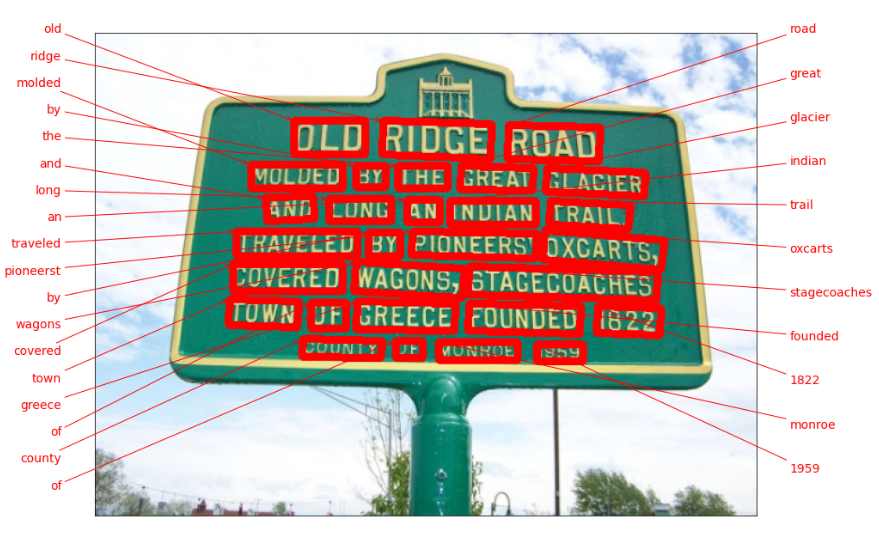
    
    - google OCR API

Texts:  

"OLD RIDGE ROAD  
MOLDED BY THE GREAT GLACIER  
AND LONG AN INDIAN TRAIL.  
TRAVELED BY PIONEERS OXCARTS,  
COVERED WAGONS, STAGECOACHES.  
TOWN OF GREECE FOUNDED 1822.  
COUNTY OF MONROE 1959"  
bounds: (119,77),(508,77),(508,294),(119,294)  

---
## Step 4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

AR을 기반으로 한 실시간 번역 어플을 만드는 것이 목표입니다. 번역을 위해서는 카메라가 읽어들인 이미지에서 실시간으로 대상이 되는 TEXT를 적절히 검출하고 텍스트화까지 이루어지는 것이 선행조건입니다. 이러한 조건을 달성하기 위한 적절한 OCR 모듈을 찾고자 합니다.  
일상적인 텍스트는 소설과는 달리 완전한 문장이 아닌 단어수준으로 표현되는 것이 일반적입니다.

Keras의 경우 단어별로 정확히 검출하여 텍스트화 하는 것을 확인 할 수 있습니다. Google 역시 단어별로 인식을 하며, 나아가 이미지상 같은 라인에 있다고 판단되는 경우 문장처럼 늘어놓는 방식으로 출력함을 확인했습니다.  

예를 들어, 첫번째 이미지의 ALL ORGANIC의 경우 keras는 'ALL' 'ORGANIC'으로, google의 경우 'ALL ORGANIC'으로써 검출했습니다.  
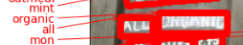
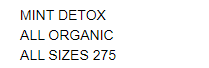

번역이 될 때, keras에서 얻은 데이터로는 '모든', '유기농' 으로 각각 번역되겠지만 google에서 얻은 데이터로는 '전부 유기농'으로 번역되겠죠.  

번역을 함에 있어서 단어를 번역 할 때에도 형용사와 명사를 구분하여 번역하는 것과 합성어를 번역 하는 것에는 큰 차이가 있습니다.

나아가 Google OCR API의 경우 연도를 인식할 수 있고, 윗 첨자와 통화 단위 등 좀 더 인식 범위가 넓은 것을 확인 할 수 있습니다.  

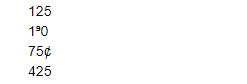

정확도를 떠나서 인식하여 표현 할 수 있는 범위가 넓다는 것은 그만큼 범용성이 뛰어남을 의미합니다.  

일상 생활에서 볼 수 있는 장면들에는 정형적인 텍스트만 존재하는 것이 아니기 때문에,  
각종 통화기호나 문맥에 알맞은 문장수준의 문자를 인식하는 **Google OCR API**를 채택 할 것입니다.

---
## after then..

- Tesseract의 경우 다양한 방법으로 시도했지만, 결국 어째서 정상동작을 하지 않았는지 알 수 없었던 점은 다소 아쉽다.
- 사실 Keras와 Google의 모듈을 비교 할 때, (본 서비스에서는)google의 압승이라서 비교 자체가 무의미했다.
- 물론 내가 설정한 목적과는 또 다른 목적을 가진 서비스의 경우에는 더 적절한 비교가 되지 않았을까 싶다.
- 비젼 테스크의 프로젝트였는데, 내가 기획한 서비스라면 자연어처리까지 접목할 수 있었던지라 좀 더 재미있게 집중 할 수 있었다.
- 재미있는 오픈소스를 알게되고 사용해본 점도 유익했다. 추후 개인 프로젝트를 진행 할 때 반드시 한번은 사용해봐야겠다.

fin.